## Recurrent Neural Networks and Hypervectors

So, one thing I am thinking about is the connection of the hypervector algebra with the nature of neural networks and other neuro-inspired AI architectures.

The primary difference between a neural network and a hypervector is that the neural network has a weight matrix, where each neuron will influence the others in a feedback manner. This matrix is very general, and people attempt to use it to learn or produce patterns. One connection with the recurrent weight matrix and the hypervector algebra is that the roll/permutation operation can be implemented by this weight matrix.


In [1]:
from pylab import *
import random_idx
import time
%matplotlib inline

height has been deprecated.

2016-03-03 11:22


In [2]:
N=10000
letter_vectors = 2 * (np.random.randn(len(random_idx.alphabet), N) > 0) - 1
print letter_vectors

[[ 1  1 -1 ..., -1  1 -1]
 [-1 -1  1 ..., -1 -1 -1]
 [ 1  1  1 ..., -1 -1  1]
 ..., 
 [ 1  1  1 ..., -1  1  1]
 [-1 -1  1 ..., -1  1  1]
 [ 1 -1 -1 ..., -1 -1 -1]]


Duration:  0.00448489189148


(array([   25.,   130.,   531.,  1323.,  2275.,  3566.,  1423.,   563.,
          136.,    28.]),
 array([-22. , -17.6, -13.2,  -8.8,  -4.4,   0. ,   4.4,   8.8,  13.2,
         17.6,  22. ]),
 <a list of 10 Patch objects>)

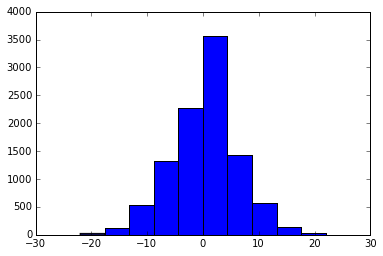

In [3]:
hypervec = np.zeros(N)

# So, we can add stuff to the hypervec as usual
letter_sequence = 'store these letters in the hypervector'

tstart = time.time()
for l in letter_sequence:
    lidx = random_idx.alphabet.find(l)
    hypervec = np.roll(hypervec, 1) + letter_vectors[lidx, :]
    
print 'Duration: ', time.time() - tstart

hist(hypervec)

Duration:  0.00448489189148


(array([   25.,   130.,   531.,  1323.,  2275.,  3566.,  1423.,   563.,
          136.,    28.]),
 array([-22. , -17.6, -13.2,  -8.8,  -4.4,   0. ,   4.4,   8.8,  13.2,
         17.6,  22. ]),
 <a list of 10 Patch objects>)

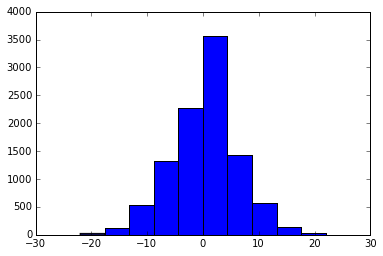

In [3]:
hypervec = np.zeros(N)
# So, we can add stuff to the hypervec as usual
letter_sequence = 'store these letters in the hypervector'
for l in letter_sequence:
    lidx = random_idx.alphabet.find(l)
    hypervec = np.roll(hypervec, 1) + letter_vectors[lidx, :]

So, now the hypervector has each letter stored at an index using the roll operation. You can see how we just roll the hypervector each time we add a letter, as if the hypervector could be taking in a continuous stream. 

We can then derefence the hypervector, and get the letters at certain positions.

r o t c e v r e p y h   e h t   n i   s r e t t e l   e s e h t   e r o t s


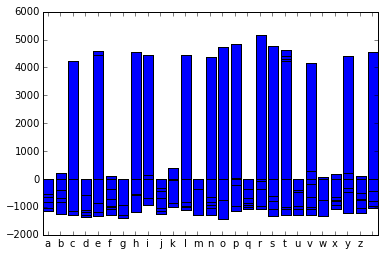

In [4]:
def letter_at_pos(pos):
    v = np.roll(hypervec, -pos)
    vals = np.dot(letter_vectors/N, v.T)
    return argmax(vals)

for i in range(len(letter_sequence)):
    print random_idx.alphabet[letter_at_pos(i)],
    

So, it prints the letters out backwards, which is what we asked. 

Now, the roll operation can be equivalently expressed as a matrix multiply. 

In [36]:
roll_matrix = np.eye(N,N)

roll_matrix = np.roll(roll_matrix, -1, axis=1)

print roll_matrix

[[ 0.  0.  0. ...,  0.  0.  1.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]


This is just an off-diagonal matrix, and this should do the exact permutation operation as roll, but it will be much more inefficient. However, this takes us a step towards generalizing hypervector algebra for recurrent neural networks, because now we can treat the roll matrix as the weights of an RNN.

First, lets just make sure it really does work the same way.

Duration:  2.77533698082


(array([   25.,   130.,   531.,  1323.,  2275.,  3566.,  1423.,   563.,
          136.,    28.]),
 array([-22. , -17.6, -13.2,  -8.8,  -4.4,   0. ,   4.4,   8.8,  13.2,
         17.6,  22. ]),
 <a list of 10 Patch objects>)

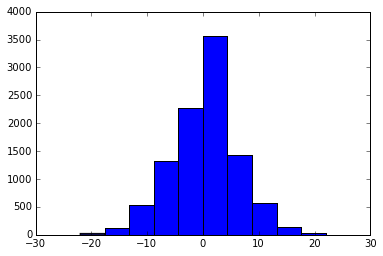

In [37]:
hyperrnn = np.zeros(N)

tstart = time.time()
for l in letter_sequence:
    lidx = random_idx.alphabet.find(l)
    
    hyperrnn = np.dot(roll_matrix, hyperrnn) + letter_vectors[lidx, :]
    
print 'Duration: ', time.time() - tstart

hist(hyperrnn)

In [7]:
print hyperrnn == hypervec

[ True  True  True ...,  True  True  True]


r o t c e v r e p y h   e h t   n i   s r e t t e l   e s e h t   e r o t s


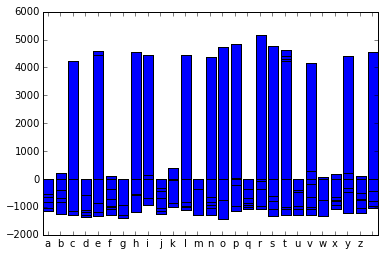

In [11]:
def letter_at_pos_rnn(pos):    
    v = np.dot(np.roll(np.eye(N,N), pos, axis=1), hyperrnn)
    
    vals = np.dot(letter_vectors/N, v.T)
    bar(arange(len(vals))+0.15, vals)   
    ax=gca()
    ax.set_xticks(arange(len(random_idx.alphabet))+0.5)
    th = ax.set_xticklabels(list(random_idx.alphabet))
    return argmax(vals)

for i in range(len(letter_sequence)):
    print random_idx.alphabet[letter_at_pos_rnn(i)],
    

In this case we have to build the unrolling matrix, and then we do matrix multiply, which is much slower. 

## Roll is a permutation matrix

So, the question is what other types of matrices are acceptable as a roll martix. Typically with an RNN, the recurrent weights are just set randomly, but here we can see the hypervector algebra can be created with a certain type of roll matrix/connectivity. The roll matrix at heart is an *orthonormal basis*, but I do not think that every index must be 1 or 0. This matrix can be made more generally, and there are certain properties about this matrix that relate to how an RNN may work and store information.

One thing to note is that there is a pattern to the roll matrix -- we cycle through all N possible permutations, and so the roll matrix cannot just be any orthonormal basis. Obviously, the identity matrix would not serve as a good roll matrix. At some point with the permutations, we will do a complete loop around the dimensions. This means that any good roll matrix should have a property like:

$$
R^N = I
$$

and 

$$
R^j \ne I \\ for j \ne (N-1)
$$

Which basically says that the roll matrix cycles through all the dimensions, and then completes a full loop after N steps. But, you can imagine a lot of orthonormal bases that would not cycle through each dimension. If the vectors in the roll_matrix are rearranged, then the orthonormal basis part stays constant. However, if you switch a few of them, you can make the roll matrix cycle back to the beginning in less than N steps. The identity matrix cycles back in 1 step. The more steps it takes to cycle, then the more positions you have in memory.



In [24]:

def random_orthogonal(n):
    a = np.random.random((n,n))
    q, r = np.linalg.qr(a)
    
    return q



In [29]:
tstart = time.time()
ro = random_orthogonal(N)
print time.time() - tstart
print ro

211.493471861
[[-0.00119626 -0.00667883  0.0167507  ..., -0.00898524  0.0038121
  -0.00408572]
 [-0.01358668 -0.00997307 -0.01749248 ...,  0.01074642 -0.00253885
  -0.01239992]
 [-0.00081618 -0.01611748 -0.00146403 ...,  0.01042127 -0.0049267
  -0.00908821]
 ..., 
 [-0.01644395  0.00655905 -0.01468457 ...,  0.00199675  0.00458501
  -0.00640067]
 [-0.00510934  0.00171628 -0.00503828 ...,  0.01593396 -0.00012652
  -0.00608739]
 [-0.01070566  0.00687661  0.00021118 ..., -0.00485666  0.00570235
  -0.00102476]]


In [30]:
np.savez('data/random_orthogonal_matrix-160303.npz', ro=ro)

Ok, so a random orthogonal matrix, should work just as well as the roll matrix... 

In [40]:
ro.shape

(10000, 10000)

Duration:  2.84244394302


(array([   30.,   273.,  1020.,  2418.,  3115.,  2130.,   792.,   190.,
           27.,     5.]),
 array([-21.21417195, -16.39716285, -11.58015375,  -6.76314465,
         -1.94613555,   2.87087355,   7.68788265,  12.50489174,
         17.32190084,  22.13890994,  26.95591904]),
 <a list of 10 Patch objects>)

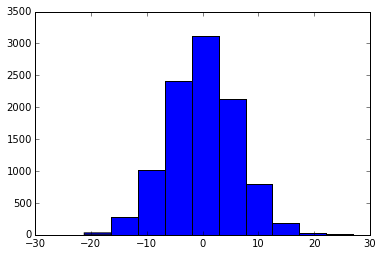

In [50]:
hyperro = np.zeros(N)

tstart = time.time()
for l in letter_sequence:
    lidx = random_idx.alphabet.find(l)
    
    hyperro = np.dot(ro, hyperro) + letter_vectors[lidx, :]
    
print 'Duration: ', time.time() - tstart

hist(hyperro)

r o t c e v r e p y h   e h t   n i   s r e t t e l   e s e h t   e r o t s


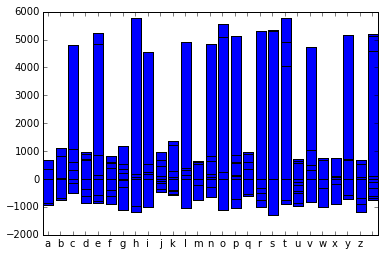

In [51]:
def letter_at_pos_ro(pos): 
    # so to read out, we need to decode the ro, which means we have to do a bunch of matrix multiplies.
    
    v = np.dot(np.linalg.matrix_power(ro, -pos), hyperro)
    #v = np.dot(np.roll(np.eye(N,N), pos, axis=1), hyperrnn)
    
    vals = np.dot(letter_vectors/N, v.T)
    bar(arange(len(vals))+0.15, vals)   
    ax=gca()
    ax.set_xticks(arange(len(random_idx.alphabet))+0.5)
    th = ax.set_xticklabels(list(random_idx.alphabet))
    return argmax(vals)

for i in range(len(letter_sequence)):
    print random_idx.alphabet[letter_at_pos_ro(i)],
    

Cool! So, yes, can just use a random orthonormal matrix as the permutation operation, and can store the hypervectors in the same fashion. 

This is terribly slow, however, because we have to compute the inverse of the matrix and raise it to a power to go backwards. However, the important point is that we have taken another step towards generalizing the hypervector math to neural networks. 

This is important because I think that the storage capacity of the hypervectors and utilizing the math is extremely important to consider in the context of an RNN. Becuase we can show that hypervectors and RNN are essentially equivalent, we can say that the storage capacity of a hypervector is similar to RNN.

I think this is essential because many don't consider the capacity of an RNN -- how much information can it keep in the recurrent dynamics? Well, the limit is set by how much a hypervector can hold. 

I think so long as the matrix is orthonormal it should work. Of course identity would not work, even though its orthonormal, and then there are tons of other permutations that won't work as well. At some point the permutation operation has to do a loop, and the max number of iterations for a loop would be N (does it have to loop at some point?). 

But random orthonormal matrix works well. The hypervector probably cannot store N values anyway, so the loop issue is not so bad. A random basis will likely not have N steps before looping, but it should be high or close to N (maybe?). 


The final difference with the RNN and hypervectors is that the hypervectors are entirely linear. An RNN often has a non-linear threshold/saturation function. What would this mean in terms of storage and capacity? How would decoding/dereferencing the memory work? 




In [45]:
ro.shape

(10000, 10000)

In [46]:
hyper_ro = np.zeros(N)
hyper_ro.shape

(10000,)

In [47]:
np.dot(ro, hyper_ro)


matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [49]:
ro = np.array(ro)